In [1]:
from collections import deque

In [2]:
import nbimporter
from fct_usuelles import lire_graphe, afficher_graphe, visualiser_graphe_par_etape

prends en paramètre un graphe dans un état (càd avec des sommets brulés) et retourne le graphe dans l'état suivante

In [3]:
def successeurs(graphe, etat_actuel):
    """
    Génère l'état suivant en propageant la brûlure aux voisins des sommets déjà brûlés.
    :param graphe: Le graphe sous forme de dictionnaire.
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets (brûlés ou non brûlés).
    :return: Nouveau dictionnaire représentant l'état des sommets après propagation.
    """
    # Copier l'état actuel pour générer le nouvel état
    nouvel_etat = etat_actuel.copy()

    # Récupérer tous les sommets brûlés
    sommets_brules = [sommet for sommet, etat in nouvel_etat.items() if etat == "brulé"]

    # Propager la brûlure aux voisins des sommets brûlés
    for sommet in sommets_brules:
        for voisin in graphe.get(sommet, []):  # Obtenir les voisins dans la liste d'adjacence
            if nouvel_etat[voisin] == "non brûlé":  # Brûler uniquement les sommets non brûlés
                nouvel_etat[voisin] = "brulé"

    return nouvel_etat

test_but : vérifie si tout les sommets sont brulées

In [4]:
def test_but(etat_actuel):
    """
    Vérifie si tous les sommets du graphe sont brûlés.
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets (brûlés ou non brûlés).
    :return: True si tous les sommets sont brûlés, False sinon.
    """
    return all(etat == "brulé" for etat in etat_actuel.values())


In [5]:
def choisir_sommet_a_bruler(etat_actuel, graphe):
    """
    Sélectionne un sommet non brûlé ayant le maximum de voisins.
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets.
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :return: Le sommet non brûlé avec le maximum de voisins, ou None si aucun sommet disponible.
    """
    # Trouver les sommets non brûlés
    sommets_non_brules = [sommet for sommet, etat in etat_actuel.items() if etat == "non brûlé"]
    
    if not sommets_non_brules:
        # Aucun sommet non brûlé
        return None

    # Trouver le sommet avec le maximum de voisins
    sommet_max_voisins = max(sommets_non_brules, key=lambda sommet: len(graphe.get(sommet, [])))

    return sommet_max_voisins


## 1ère méthode

In [6]:
def recherche(graphe, etat_initial, successeurs, test_but):
    """
    Algorithme générique de recherche pour brûler un graphe en choisissant un sommet par étape.
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_initial: Dictionnaire représentant l'état initial des sommets (brûlés ou non brûlés).
    :param successeurs: Fonction qui génère l'état suivant (propagation).
    :param test_but: Fonction qui vérifie si tous les sommets sont brûlés.
    :return: Chemin (liste des états successifs), sommets brûlés activement à chaque étape, et coût total.
    """
    # Initialisation : créer la liste des états à traiter
    etats_a_traiter = deque([{"etat": etat_initial, "chemin": [etat_initial], "cout": 0, "brules_actifs": []}])

    while etats_a_traiter:
        # Extraire un état
        noeud = etats_a_traiter.pop()

        # Vérifier si tous les sommets sont brûlés
        if test_but(noeud["etat"]):
            return noeud["chemin"], noeud["brules_actifs"], noeud["cout"]

        # Choisir un nouveau sommet à brûler activement
        nouveau_sommet = choisir_sommet_a_bruler(noeud["etat"], graphe)
        if nouveau_sommet is None:
            # Si aucun sommet à brûler n'est disponible, retourner l'état actuel
            continue

        # Marquer le nouveau sommet comme "brûlé"
        etat_suivant = noeud["etat"].copy()
        etat_suivant[nouveau_sommet] = "brulé"

        # Propager la brûlure à partir des sommets déjà brûlés
        etat_suivant = successeurs(graphe, etat_suivant)

        # Ajouter le nouvel état à la liste des états à traiter
        etats_a_traiter.append({
            "etat": etat_suivant,
            "chemin": noeud["chemin"] + [etat_suivant],
            "cout": noeud["cout"] + 1,  # Chaque étape coûte 1
            "brules_actifs": noeud["brules_actifs"] + [nouveau_sommet]
        })

    # Si aucun état final n'est trouvé
    return None, [], float("inf")


In [7]:
#fichier = 'instances\Stranke94\Stranke94.mtx'
#fichier = 'instances\bn-mouse_visual-cortex_1\bn-mouse_visual-cortex_1.edges'
fichier = 'instances\karate\karate.mtx'
#fichier = 'instances\fb-pages-government\fb-pages-government.edges'

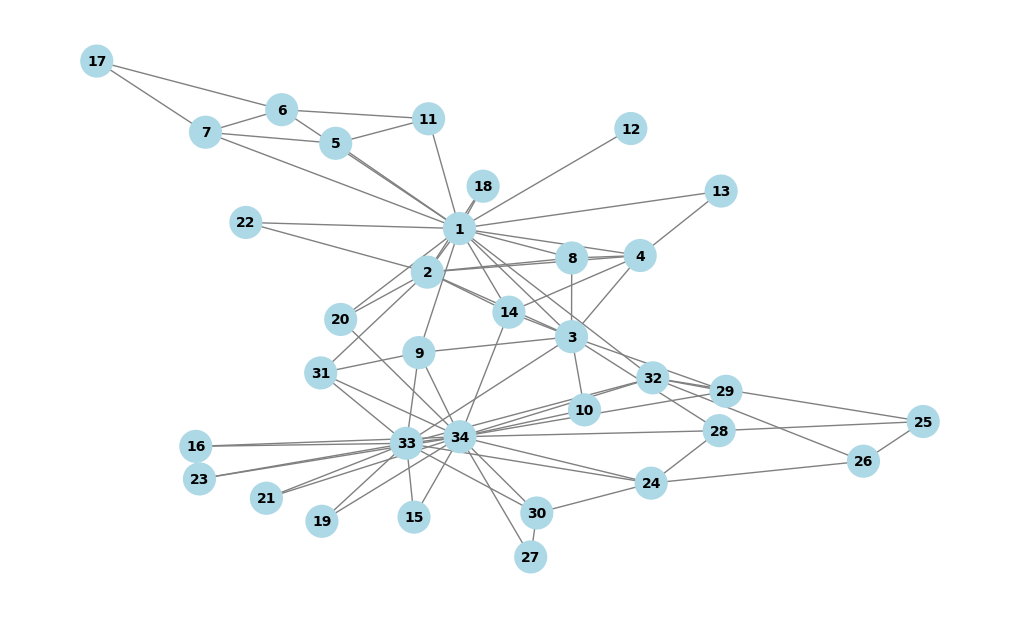

In [8]:
# Charger un graphe avec la fonction lire_graphe
graphe = lire_graphe(fichier)

afficher_graphe(graphe)

In [9]:
etat_initial = {sommet: "non brûlé" for sommet in graphe}

chemin, sommets_actifs, cout = recherche(graphe, etat_initial, successeurs, test_but)

sommets_actifs

[34, 1, 17]

dire un sommet va etre brulé au 3 tour par exemple
notre solution (du 2eme algo) sera le  centre (sommet) de la boule ayant le rayon le plus grand

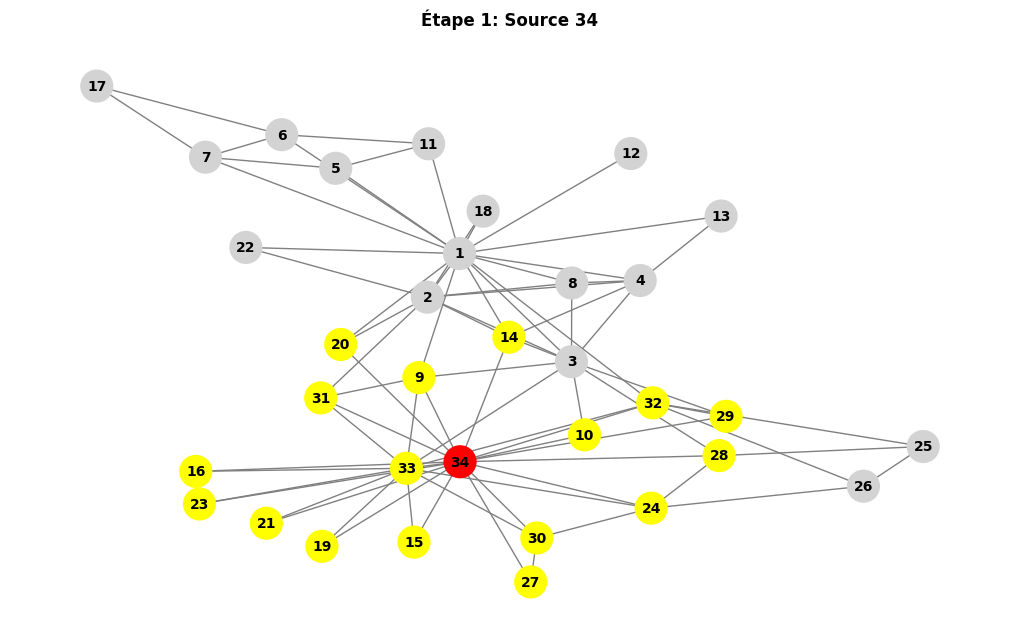

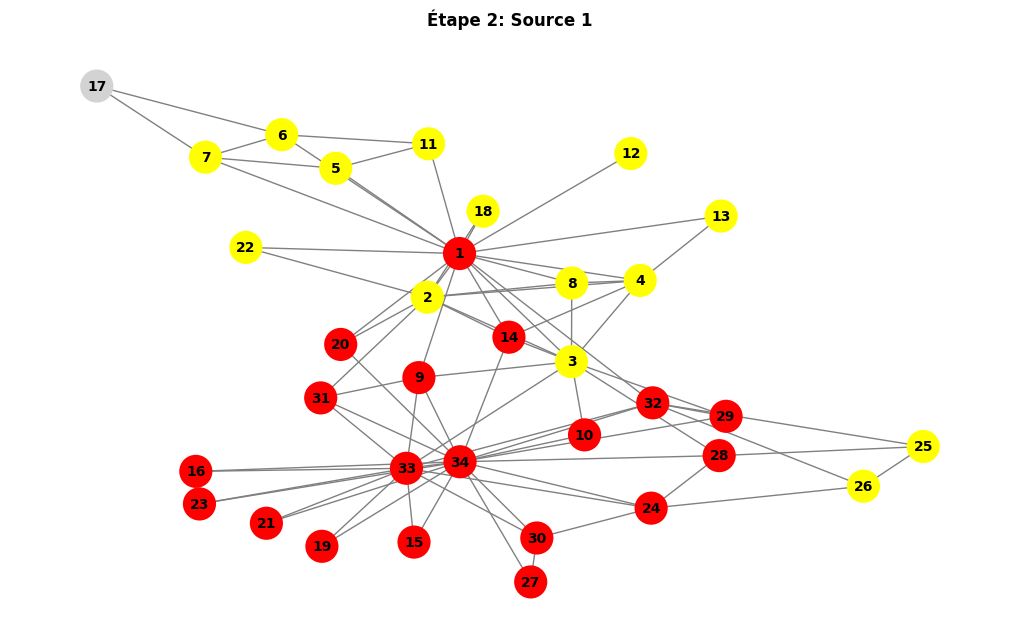

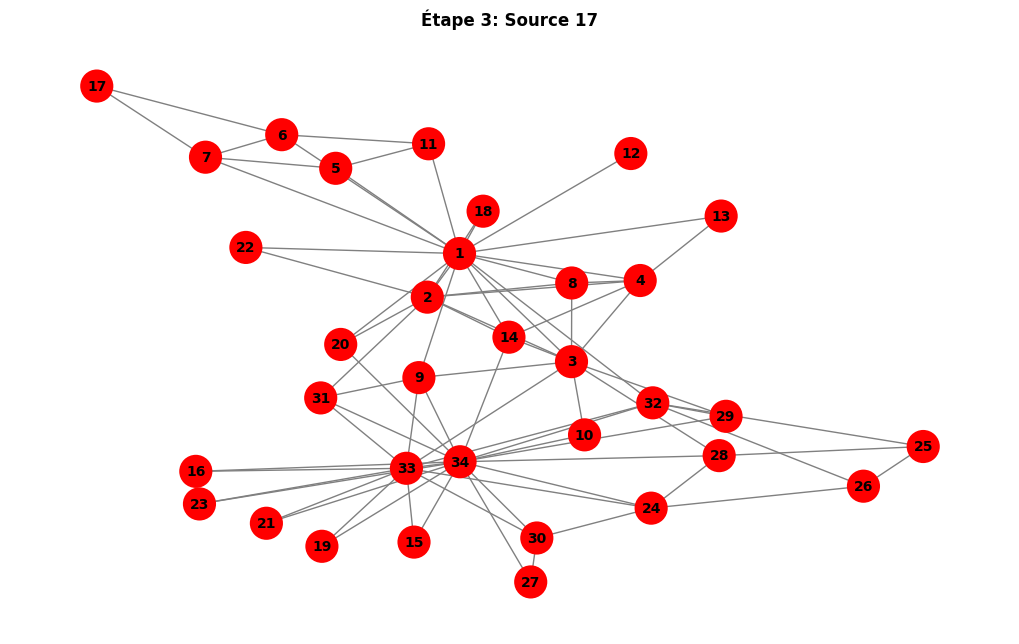

In [10]:
# Visualiser le graphe par étape
visualiser_graphe_par_etape(graphe, sommets_actifs)
